# Evaluating velocities on body surfaces

For use in mechanics problems, it is important to be able to output
the velocity of the points on the surfaces of bodies at a given system state
and time. We use the function `surface_velocity!` for this. Here,
we will demonstrate its use, and particularly, its various options.

We will use a simple problem, consisting of two flat plates connected
by a `RevoluteJoint`, and one of the plates connected to the inertial
system by a `FreeJoint2d`, oscillating in y coordinate only.

In [1]:
using RigidBodyTools
using Plots

## Set up the bodies, joints, and motion

In [2]:
body1 = Plate(1.0,200)
body2 = deepcopy(body1)

bodies = BodyList([body1,body2])

BodyList(Body[Open polygon with 2 vertices and 200 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
, Open polygon with 2 vertices and 200 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0
])

Joint 1, connecting body 1 to inertial system

In [3]:
Xp_to_j1 = MotionTransform(0.0,0.0,0.0)
Xch_to_j1 = MotionTransform(-0.5,0.0,0.0)
dofs1 = [ConstantVelocityDOF(0),ConstantVelocityDOF(0),OscillatoryDOF(1.0,2π,0,0.0)]
joint1 = Joint(FreeJoint2d,0,Xp_to_j1,1,Xch_to_j1,dofs1)

Joint of dimension 2 and type FreeJoint2d
   Constrained dofs = [1, 2, 3]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


Joint 2, connecting body 2 to body 1

In [4]:
Xp_to_j2 = MotionTransform(0.5,0.0,0.0)
Xch_to_j2 = MotionTransform(-0.5,0.0,0.0)
dofs2 = [OscillatoryDOF(π/4,2π,-π/4,0.0)]
joint2 = Joint(RevoluteJoint,1,Xp_to_j2,2,Xch_to_j2,dofs2)

Joint of dimension 2 and type RevoluteJoint
   Constrained dofs = [1]
   Exogenous dofs = Int64[]
   Unconstrained dofs = Int64[]


Assemble, and get the initial joint state vector at t = 0

In [5]:
joints = [joint1,joint2]
ls = RigidBodyMotion(joints,bodies)
t = 0
x = init_motion_state(bodies,ls;tinit=t)

4-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.5553603672697958

Let's plot the bodies, just to visualize their current configuration.

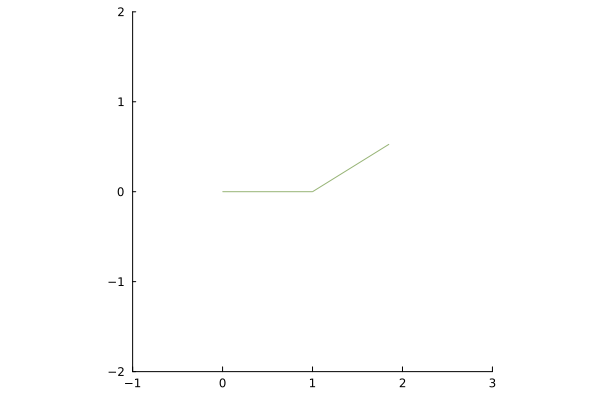

In [6]:
update_body!(bodies,x,ls)
plot(bodies,xlim=(-1,3),ylim=(-2,2))

Because of the phase difference, joint 2 is bent at an angle initially.

## Evaluate velocity on body points
First, initialize vectors for the `u` and `v` components in this 2d example,
using the `zero_body` function.

In [7]:
u, v = zero_body(bodies), zero_body(bodies)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

Now evaluate the velocities at time 0

In [8]:
surface_velocity!(u,v,bodies,x,ls,t)

We can plot these on each body using the `view` function for `BodyList`.
For example, the vectors of u and v velocities on body 1 are

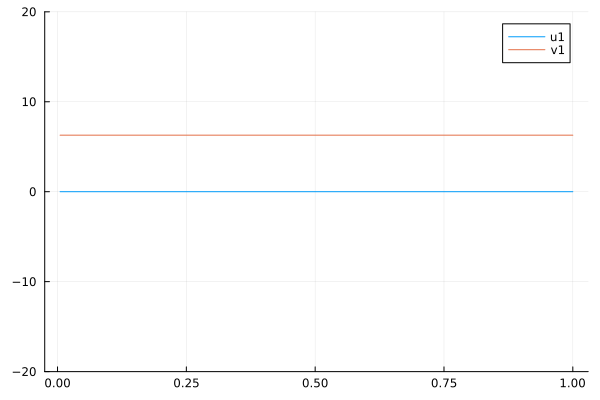

In [9]:
bodyid = 1
s = arccoord(bodies[bodyid])
plot(s,view(u,bodies,bodyid),ylim=(-20,20),label="u1")
plot!(s,view(v,bodies,bodyid),label="v1")

This shows a pure vertical translation. On body 2,
we see a mixture of the translation of body 1, plus
the rotation of joint 2, which is reflected in the linear variation. Since the plate is at an angle,
some of this rotation shows up as a negative u component.

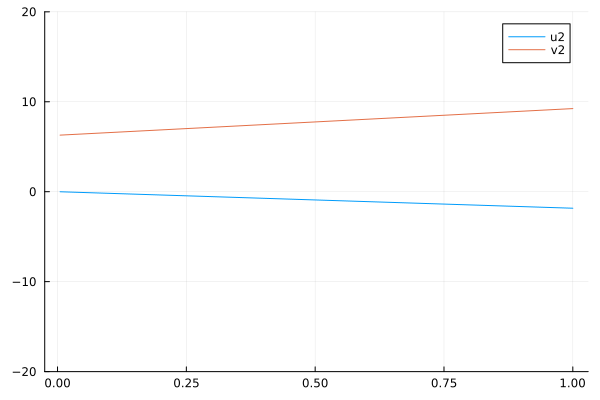

In [10]:
bodyid = 2
s = arccoord(bodies[bodyid])
plot(s,view(u,bodies,bodyid),ylim=(-20,20),label="u2")
plot!(s,view(v,bodies,bodyid),label="v2")

We can compute these velocities in different components, using the optional `axes`
argument. For example, let's see the velocities on body 2 in its own coordinate
system

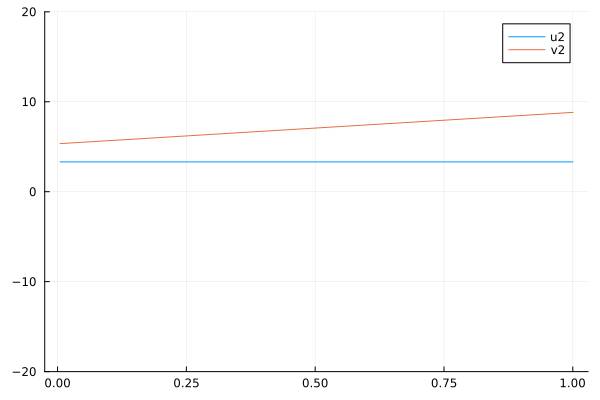

In [11]:
surface_velocity!(u,v,bodies,x,ls,t;axes=2)
bodyid = 2
s = arccoord(bodies[bodyid])
plot(s,view(u,bodies,bodyid),ylim=(-20,20),label="u2")
plot!(s,view(v,bodies,bodyid),label="v2")

Now only the v component (the component perpendicular to the plate) depicts
the rotation, and the u component has only a portion of the translational motion
from joint 1.

We can also compute the velocity relative to a body reference frame, using
the optional `frame` argument. Let's compute the velocities relative
to the velocity of body 1 (and in body 1 coordinates) and plot them.

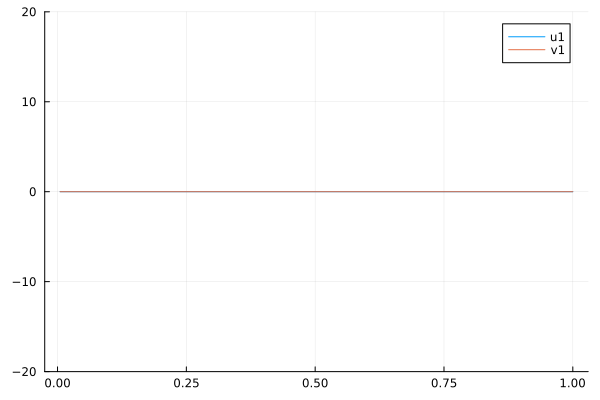

In [12]:
surface_velocity!(u,v,bodies,x,ls,t;axes=1,frame=1)
bodyid = 1
s = arccoord(bodies[bodyid])
plot(s,view(u,bodies,bodyid),ylim=(-20,20),label="u1")
plot!(s,view(v,bodies,bodyid),label="v1")

Body 1 has no velocity in this reference frame. And body 2 has only
a pure rotation...

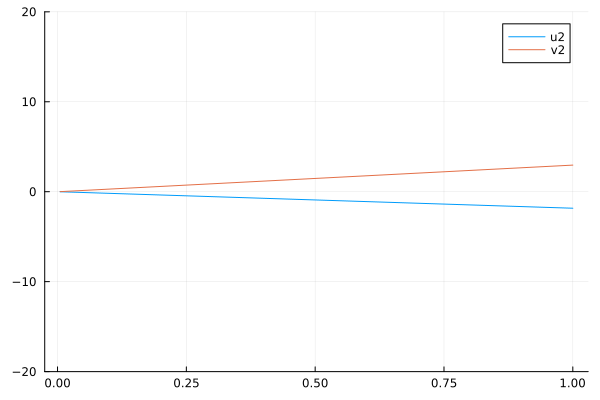

In [13]:
bodyid = 2
s = arccoord(bodies[bodyid])
plot(s,view(u,bodies,bodyid),ylim=(-20,20),label="u2")
plot!(s,view(v,bodies,bodyid),label="v2")

We do not have to remove all of the motion of the reference body
when we compute velocity in a moving reference frame. We
can use the `motion_part` keyword argument to remove only, e.g., `:angular`
or `:linear` part (instead of `:full`, the default). For example,
if we remove the angular part of body 2's motion, we are left with only
the translation from joint 1

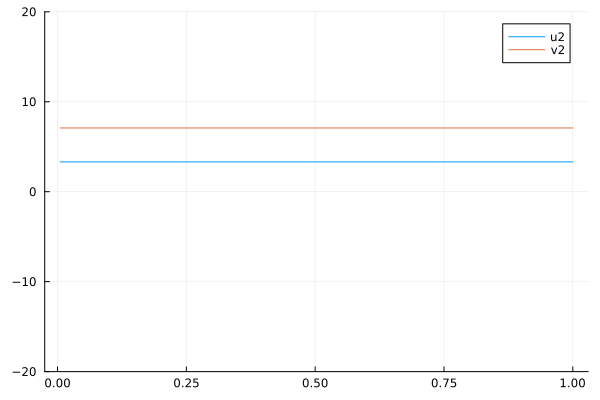

In [14]:
surface_velocity!(u,v,bodies,x,ls,t;axes=2,frame=2,motion_part=:angular)
bodyid = 2
s = arccoord(bodies[bodyid])
plot(s,view(u,bodies,bodyid),ylim=(-20,20),label="u2")
plot!(s,view(v,bodies,bodyid),label="v2")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*